Load SOTA music recognizion system
---

22050


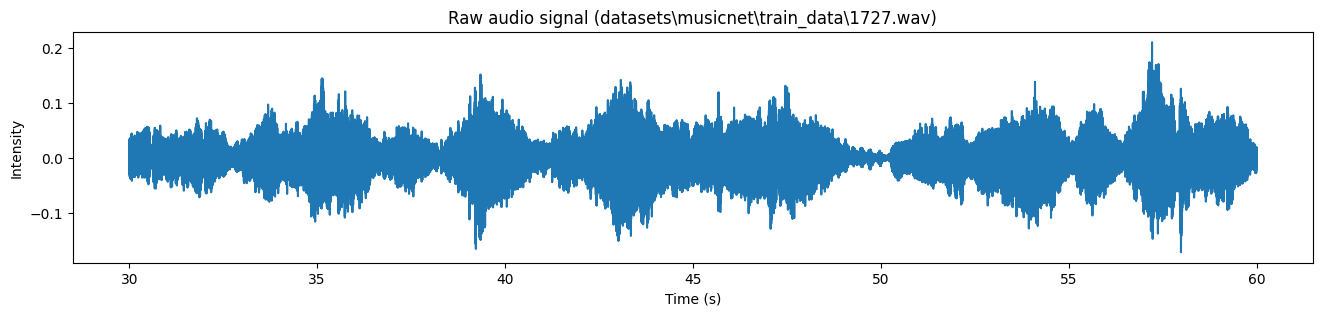

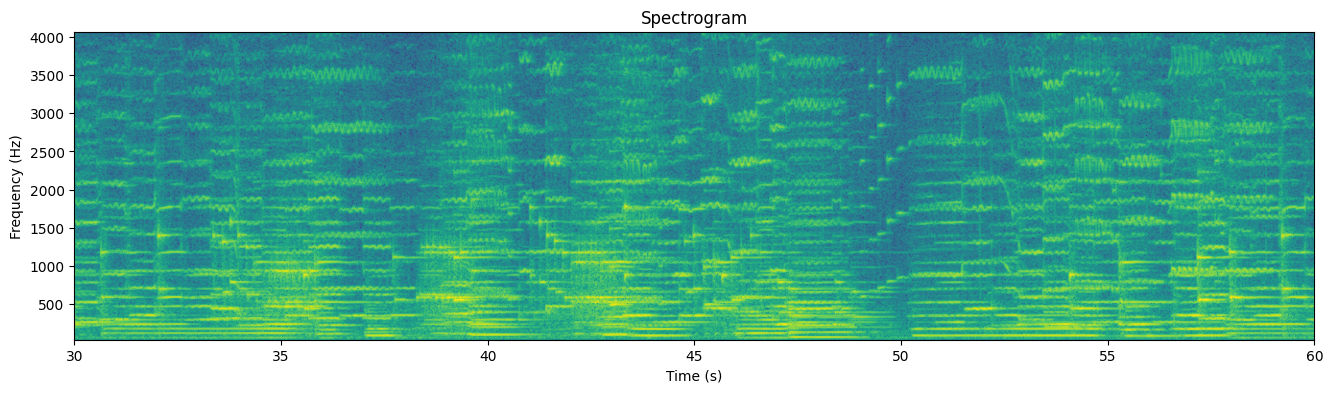

In [49]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

folder_path = os.getcwd()
file_path = "datasets\\musicnet\\train_data\\1727.wav"
y, sr = librosa.load(folder_path + "\\..\\..\\..\\" + file_path)
sr = int(sr)
print(sr)

start_time, time_delta = 30, 30
start_freq, end_freq = 3, 378
n_fft = 2048  # lentgh of rolling window
hop_length = n_fft // 4  # intersection between windows
end_time = start_time + time_delta
spect = np.abs(librosa.stft(
    y[start_time * sr:end_time * sr],
    n_fft=n_fft, hop_length=hop_length
))[start_freq: end_freq]

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(start_time + np.arange(int(sr * time_delta)) / sr, y[start_time * sr:end_time * sr])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Intensity")
ax.set_title(f"Raw audio signal ({file_path})")
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.imshow(
    np.log(spect), origin='lower', aspect='auto',
    extent=[
        start_time, start_time + spect.shape[1] * hop_length / sr,
        start_freq * sr / n_fft, end_freq * sr / n_fft
    ],
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram")
plt.show()

time1: 48.18122448979592
time2: 42.95673469387755


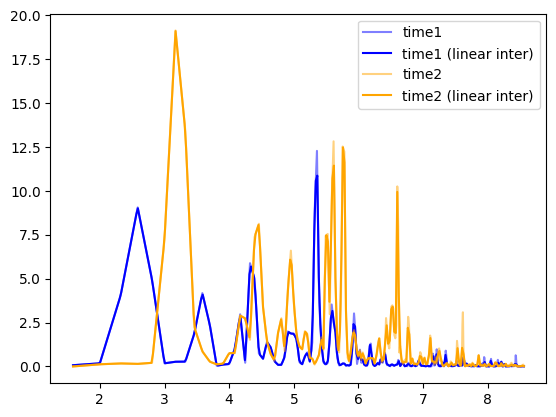

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
time1, time2 = 783, 558
print(f"time1: {start_time + time1 * hop_length / sr}")
print(f"time2: {start_time + time2 * hop_length / sr}")
T = np.log2(np.arange(start_freq, end_freq))
T_interp = np.linspace(T.min(), T.max(), 250)
array1 = spect[:, time1]
array2 = spect[:, time2]
plt.plot(T, array1, label="time1", color='blue', alpha=0.5)
interp_0 = np.interp(T_interp, T, array1)
plt.plot(T_interp, interp_0, label="time1 (linear inter)", color='blue')
plt.plot(T, array2, label="time2", color='orange', alpha=0.5)
interp_100 = np.interp(T_interp, T, array2)
plt.plot(T_interp, interp_100, label="time2 (linear inter)", color='orange')
plt.legend(loc='best')
plt.show()

In [84]:
a = np.arange(20).reshape(4, 5)
print(a)
b = a[np.arange(4), np.array([0, 2, 1, 0])]
b

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]


array([ 0,  7, 11, 15])

In [37]:
10 * hop_length / sr, 10 * sr / n_fft

(0.23219954648526078, 107.666015625)

In [38]:
m_diff = 1 / (12)
60 * m_diff, 2000 * m_diff, 380 * sr / n_fft

(5.0, 166.66666666666666, 4091.30859375)

In [ ]:
import torch
from torch import nn

class MusicModel(nn.Module):
    """
    Model that takes a spectogram of shape (F, T) and returns
    an array (12, T) where at each time is the probability distribuion
    of possible notes.
    """
    sr = 22050  # sampling rate
    n_fft = 2048  # length of fft window
    hop_length = n_fft // 4  # distance between consecutive windows
    F = 120  # number of sampled frequencies

    def __init__(self, k: int = 4, c: int = 4) -> None:
        super().__init__()
        f_reach = int(50 / (sr / n_fft))  # distance to another note
        t_reach = int(sr / (2 * hop_length))  # 0.5s
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, c, (1 + 2 * t_reach, 1 + 2 * f_reach), padding=(t_reach, f_reach)),
            nn.GELU(),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(self.F, k * self.F),
            nn.GELU(),
            nn.Linear(k * self.F, self.F),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c, c**2, (1 + 2 * t_reach, 1 + 2 * f_reach), padding=(t_reach, f_reach)),
            nn.GELU(),
        )
        self.linear2 = nn.Linear(c**2 * self.F, 12)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """x: (..., F, T)"""
        x = x.transpose(-1, -2).unsqueeze(-3)  # (..., 1, T, F)
        x = self.conv1(x)  # (..., c, T, F)
        x = self.linear1(x)  # (..., c, T, F)
        x = self.conv2(x)  # (..., c**2, T, F)
        x = x.transpose(-2, -3).flatten(-2, -1)  # (..., T, c**2 * F)
        x = self.linear2(x)  # (..., T, 12)
        return x.T

In [39]:
10 * sr / hop_length

430.6640625

In [22]:
import numpy as np
a = np.arange(10)
a.reshape(2, 5)

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [73]:
model = MusicModel()
output = model(torch.from_numpy(spect))
spect.shape, output.shape

((120, 431), torch.Size([12, 431]))